# Fake News Detection - Transformer Models

This notebook implements state-of-the-art transformer-based models for fake news detection using pre-trained language models from Hugging Face.

## Objectives
- Implement DistilBERT (lightweight transformer)
- Implement BERT-base (comprehensive transformer)
- Fine-tune pre-trained models on the fake news dataset
- Evaluate and compare transformer models
- Compare with classical ML and deep learning approaches
- Identify the best overall model for fake news detection


In [1]:
# Import basic libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Add src directory to path
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import custom utilities
from preprocessing import load_processed_data
from models import (
    calculate_metrics, print_metrics, plot_confusion_matrix,
    print_classification_report, compare_models, plot_model_comparison,
    plot_all_metrics_comparison
)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Basic libraries imported successfully!")
print(f"Project root: {project_root}")


Basic libraries imported successfully!
Project root: /Users/manalaamir/Documents/Fake News Detection -NLP


In [2]:
# Import transformer libraries
import time

print("Step 1: Importing PyTorch...")
start = time.time()
import torch
print(f"PyTorch imported in {time.time() - start:.2f} seconds")

print("Step 2: Importing Transformers...")
start = time.time()
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
print(f"Transformers imported in {time.time() - start:.2f} seconds")

print("Step 3: Importing other libraries...")
start = time.time()
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
print(f"Other libraries imported in {time.time() - start:.2f} seconds")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("All transformer libraries imported successfully!")


Step 1: Importing PyTorch...
PyTorch imported in 1.02 seconds
Step 2: Importing Transformers...
Transformers imported in 6.84 seconds
Step 3: Importing other libraries...
Other libraries imported in 0.00 seconds
Using device: cpu
All transformer libraries imported successfully!


## 1. Load and Prepare Data


In [3]:
# Load processed training and test data
train_path = os.path.join(project_root, 'data', 'processed', 'train_data.csv')
test_path = os.path.join(project_root, 'data', 'processed', 'test_data.csv')

print("Loading processed datasets...")
train_df = load_processed_data(train_path)
test_df = load_processed_data(test_path)

# Extract text and labels
X_train_text = train_df['title_cleaned'].astype(str).tolist()
X_test_text = test_df['title_cleaned'].astype(str).tolist()
y_train = train_df['real'].values
y_test = test_df['real'].values

print(f"\nTraining samples: {len(X_train_text)}")
print(f"Test samples: {len(X_test_text)}")
print(f"\nTraining labels distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest labels distribution:")
print(pd.Series(y_test).value_counts())


Loading processed datasets...

Training samples: 18556
Test samples: 4640

Training labels distribution:
1    13952
0     4604
Name: count, dtype: int64

Test labels distribution:
1    3489
0    1151
Name: count, dtype: int64


## 2. Model 1: DistilBERT


In [4]:
# Load DistilBERT tokenizer and model
model_name = "distilbert-base-uncased"
print(f"Loading {model_name}...")

tokenizer_distilbert = AutoTokenizer.from_pretrained(model_name)
model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

print(f"Model loaded: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in model_distilbert.parameters()):,}")


Loading distilbert-base-uncased...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: distilbert-base-uncased
Model parameters: 66,955,010


In [5]:
# Tokenize the data (without return_tensors for dataset compatibility)
print("Tokenizing training data...")
train_encodings = tokenizer_distilbert(
    X_train_text,
    truncation=True,
    padding=True,
    max_length=128
)

print("Tokenizing test data...")
test_encodings = tokenizer_distilbert(
    X_test_text,
    truncation=True,
    padding=True,
    max_length=128
)

print("Tokenization complete!")


Tokenizing training data...
Tokenizing test data...
Tokenization complete!


In [6]:
# Create PyTorch dataset
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    
    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, y_train)
test_dataset = NewsDataset(test_encodings, y_test)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Training dataset size: 18556
Test dataset size: 4640


In [7]:
# Define metrics function for Trainer
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results_distilbert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="no",
    save_strategy="no",
    load_best_model_at_end=False,
)

# Create trainer
trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer_distilbert,
    compute_metrics=compute_metrics,
)

print("Trainer configured. Starting training...")


Trainer configured. Starting training...


In [8]:
# Train DistilBERT model
print("Training DistilBERT model (this may take several minutes)...")
start_time = time.time()

trainer_distilbert.train()

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Training DistilBERT model (this may take several minutes)...


Step,Training Loss
100,0.602400
200,0.495900
300,0.438700
400,0.456600
500,0.430400
600,0.427700
700,0.385700
800,0.390400
900,0.404700
1000,0.382000



Training completed in 1043.34 seconds (17.39 minutes)


Evaluating DistilBERT model...


MODEL: DistilBERT

Overall Metrics:
  Accuracy:  0.8547
  Precision: 0.8510
  Recall:    0.8547
  F1-Score:  0.8523

Class 0 (Fake News) Metrics:
  Precision: 0.7287
  Recall:    0.6603
  F1-Score:  0.6928

Class 1 (Real News) Metrics:
  Precision: 0.8913
  Recall:    0.9189
  F1-Score:  0.9049


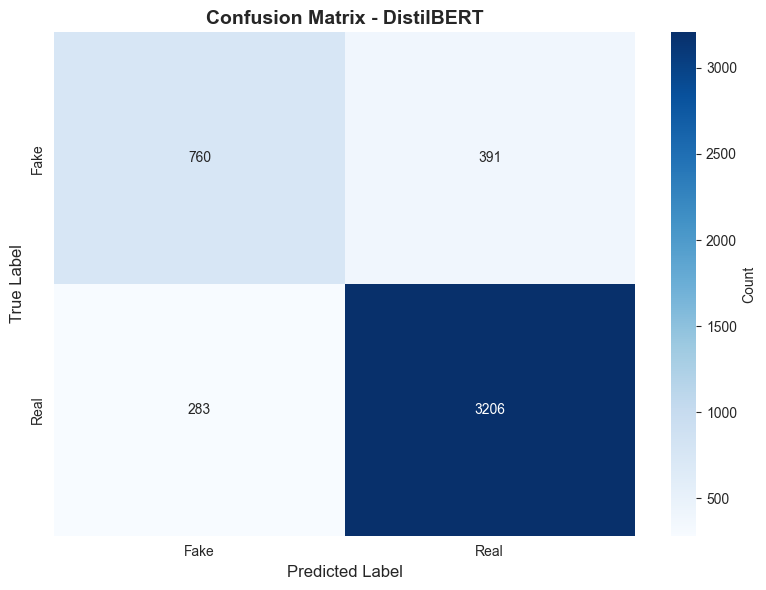


Classification Report - DistilBERT
              precision    recall  f1-score   support

        Fake     0.7287    0.6603    0.6928      1151
        Real     0.8913    0.9189    0.9049      3489

    accuracy                         0.8547      4640
   macro avg     0.8100    0.7896    0.7988      4640
weighted avg     0.8510    0.8547    0.8523      4640



In [24]:
# Evaluate DistilBERT model
print("Evaluating DistilBERT model...")
predictions_distilbert = trainer_distilbert.predict(test_dataset)
y_pred_distilbert = np.argmax(predictions_distilbert.predictions, axis=1)

# Calculate metrics
metrics_distilbert = calculate_metrics(y_test, y_pred_distilbert, "DistilBERT")
print_metrics(metrics_distilbert)

# Create results directory if it doesn't exist
results_dir = os.path.join(project_root, 'results')
os.makedirs(results_dir, exist_ok=True)
viz_dir = os.path.join(results_dir, 'visualizations')
os.makedirs(viz_dir, exist_ok=True)

# Plot and save confusion matrix
plot_confusion_matrix(y_test, y_pred_distilbert, "DistilBERT",
                     save_path=os.path.join(viz_dir, 'distilbert_confusion_matrix.png'))
print_classification_report(y_test, y_pred_distilbert, "DistilBERT")


## 3. Model 2: BERT-base


In [10]:
# Load BERT tokenizer and model
model_name = "bert-base-uncased"
print(f"Loading {model_name}...")

tokenizer_bert = AutoTokenizer.from_pretrained(model_name)
model_bert = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

print(f"Model loaded: {model_name}")
print(f"Model parameters: {sum(p.numel() for p in model_bert.parameters()):,}")


Loading bert-base-uncased...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: bert-base-uncased
Model parameters: 109,483,778


In [11]:
# Tokenize the data (without return_tensors for dataset compatibility)
print("Tokenizing training data...")
train_encodings_bert = tokenizer_bert(
    X_train_text,
    truncation=True,
    padding=True,
    max_length=128
)

print("Tokenizing test data...")
test_encodings_bert = tokenizer_bert(
    X_test_text,
    truncation=True,
    padding=True,
    max_length=128
)

print("Tokenization complete!")


Tokenizing training data...
Tokenizing test data...
Tokenization complete!


In [12]:
# Create PyTorch datasets
train_dataset_bert = NewsDataset(train_encodings_bert, y_train)
test_dataset_bert = NewsDataset(test_encodings_bert, y_test)

print(f"Training dataset size: {len(train_dataset_bert)}")
print(f"Test dataset size: {len(test_dataset_bert)}")


Training dataset size: 18556
Test dataset size: 4640


In [13]:
# Training arguments for BERT
training_args_bert = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="no",
    save_strategy="no",
    load_best_model_at_end=False,
)

# Create trainer
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=train_dataset_bert,
    tokenizer=tokenizer_bert,
    compute_metrics=compute_metrics,
)

print("Trainer configured. Starting training...")


Trainer configured. Starting training...


In [14]:
# Train BERT model
print("Training BERT model (this may take several minutes)...")
start_time = time.time()

trainer_bert.train()

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Training BERT model (this may take several minutes)...


Step,Training Loss
100,0.644000
200,0.507300
300,0.454600
400,0.468400
500,0.461700
600,0.434600
700,0.390400
800,0.394700
900,0.401400
1000,0.374600



Training completed in 1910.49 seconds (31.84 minutes)


Evaluating BERT model...


MODEL: BERT-base

Overall Metrics:
  Accuracy:  0.8569
  Precision: 0.8532
  Recall:    0.8569
  F1-Score:  0.8545

Class 0 (Fake News) Metrics:
  Precision: 0.7330
  Recall:    0.6655
  F1-Score:  0.6976

Class 1 (Real News) Metrics:
  Precision: 0.8929
  Recall:    0.9200
  F1-Score:  0.9063


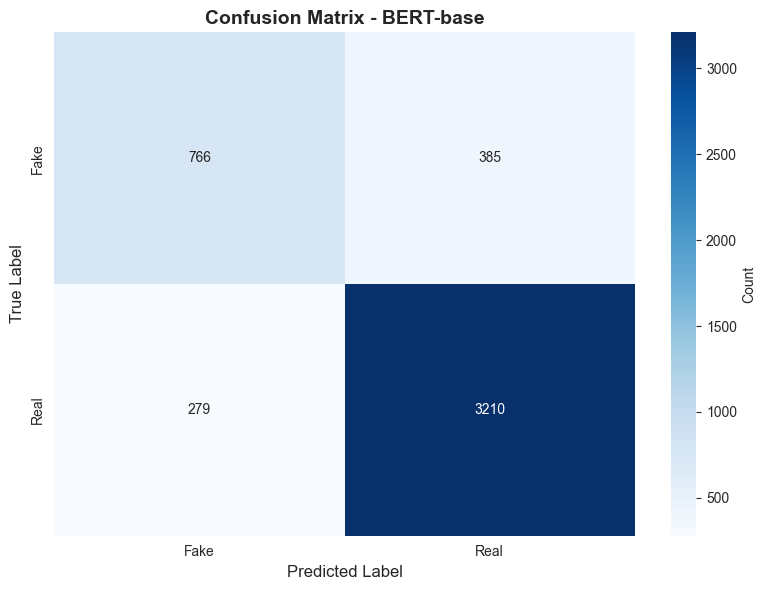


Classification Report - BERT-base
              precision    recall  f1-score   support

        Fake     0.7330    0.6655    0.6976      1151
        Real     0.8929    0.9200    0.9063      3489

    accuracy                         0.8569      4640
   macro avg     0.8130    0.7928    0.8019      4640
weighted avg     0.8532    0.8569    0.8545      4640



In [25]:
# Evaluate BERT model
print("Evaluating BERT model...")
predictions_bert = trainer_bert.predict(test_dataset_bert)
y_pred_bert = np.argmax(predictions_bert.predictions, axis=1)

# Calculate metrics
metrics_bert = calculate_metrics(y_test, y_pred_bert, "BERT-base")
print_metrics(metrics_bert)

# Plot and save confusion matrix
plot_confusion_matrix(y_test, y_pred_bert, "BERT-base",
                     save_path=os.path.join(viz_dir, 'bert_confusion_matrix.png'))
print_classification_report(y_test, y_pred_bert, "BERT-base")


## 4. Transformer Models Comparison


In [16]:
# Collect transformer model results
transformer_results = [metrics_distilbert, metrics_bert]

# Create comparison dataframe
comparison_df = compare_models(transformer_results)
print("\nTransformer Models Comparison:")
print("=" * 80)
print(comparison_df.round(4))
print("=" * 80)



Transformer Models Comparison:
            accuracy  precision  recall  f1_score
model_name                                       
DistilBERT    0.8547     0.8510  0.8547    0.8523
BERT-base     0.8569     0.8532  0.8569    0.8545


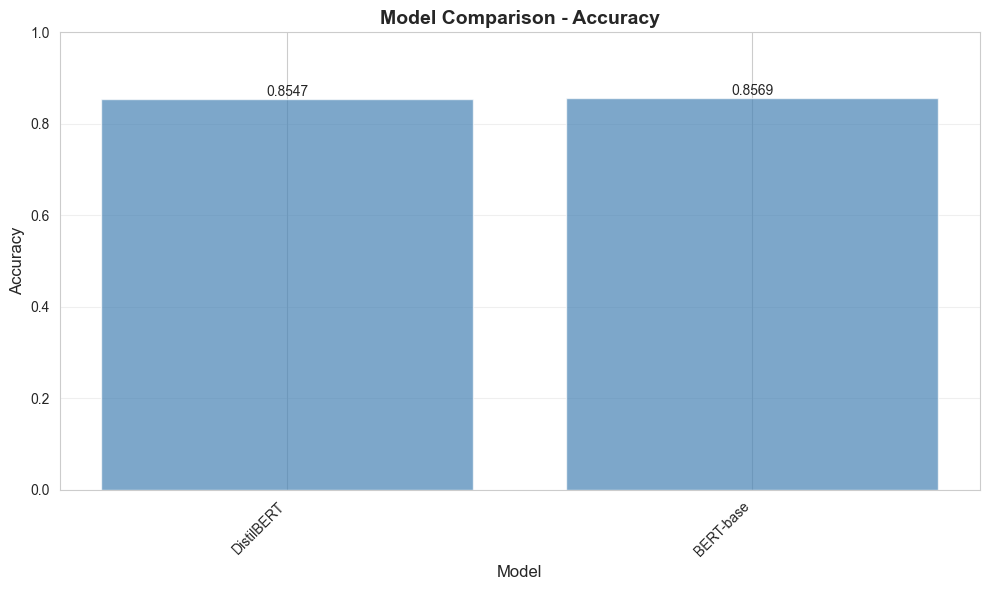

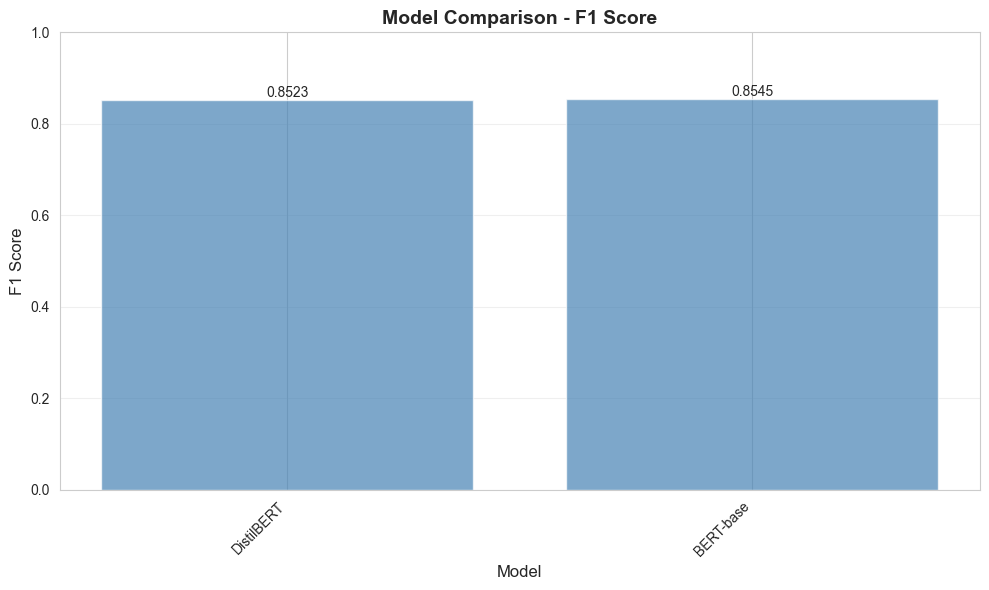

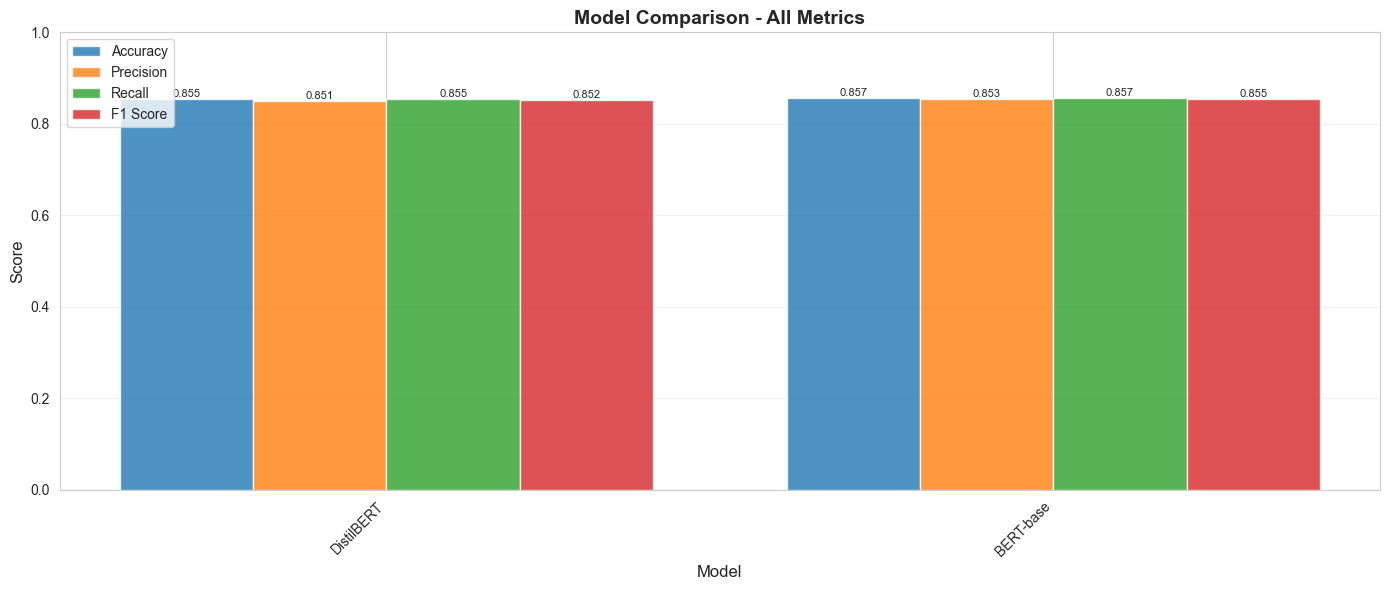

In [17]:
# Visualize comparison
plot_model_comparison(transformer_results, metric='accuracy')
plot_model_comparison(transformer_results, metric='f1_score')
plot_all_metrics_comparison(transformer_results)


## 5. Final Model Comparison: All Approaches

This section compares all models across classical ML, deep learning, and transformer approaches.


In [26]:
# Final Model Comparison - All Approaches
# Results compiled from all notebooks

# Classical ML models (from Notebook 03)
classical_results = [
    {'model_name': 'Naive Bayes', 'accuracy': 0.8373, 'precision': 0.8290, 'recall': 0.8373, 'f1_score': 0.8268},
    {'model_name': 'Logistic Regression', 'accuracy': 0.8086, 'precision': 0.8309, 'recall': 0.8086, 'f1_score': 0.8157},
    {'model_name': 'Support Vector Machine', 'accuracy': 0.7929, 'precision': 0.8246, 'recall': 0.7929, 'f1_score': 0.8022},
    {'model_name': 'Random Forest', 'accuracy': 0.8063, 'precision': 0.7985, 'recall': 0.8063, 'f1_score': 0.8013}
]

# Deep Learning models (from Notebook 04)
dl_results = [
    {'model_name': 'CNN', 'accuracy': 0.8321, 'precision': 0.8261, 'recall': 0.8321, 'f1_score': 0.8280},
    {'model_name': 'LSTM', 'accuracy': 0.7519, 'precision': 0.5654, 'recall': 0.7519, 'f1_score': 0.6455},
    {'model_name': 'CNN-LSTM Hybrid', 'accuracy': 0.7519, 'precision': 0.5654, 'recall': 0.7519, 'f1_score': 0.6455}
]

# Transformer models (from this notebook)
transformer_results_all = [
    {'model_name': 'BERT-base', 'accuracy': 0.8569, 'precision': 0.8532, 'recall': 0.8569, 'f1_score': 0.8545},
    {'model_name': 'DistilBERT', 'accuracy': 0.8547, 'precision': 0.8510, 'recall': 0.8547, 'f1_score': 0.8523}
]

# Combine all results
all_results = classical_results + dl_results + transformer_results_all

# Create comprehensive comparison dataframe
all_comparison_df = pd.DataFrame(all_results)
all_comparison_df = all_comparison_df.set_index('model_name').sort_values('accuracy', ascending=False)

print("Final Model Comparison - All Approaches")
print("=" * 80)
print("\nAll Models Ranked by Accuracy:")
print(all_comparison_df.round(4))
print("=" * 80)

# Identify best model
best_model = all_comparison_df.iloc[0]
print(f"\nBest Overall Model: {best_model.name}")
print(f"  Accuracy: {best_model['accuracy']:.4f}")
print(f"  Precision: {best_model['precision']:.4f}")
print(f"  Recall: {best_model['recall']:.4f}")
print(f"  F1-Score: {best_model['f1_score']:.4f}")

# Save final comparison results
results_dir = os.path.join(project_root, 'results')
os.makedirs(results_dir, exist_ok=True)
metrics_dir = os.path.join(results_dir, 'metrics')
os.makedirs(metrics_dir, exist_ok=True)

# Save comparison dataframe
comparison_csv_path = os.path.join(metrics_dir, 'final_model_comparison.csv')
all_comparison_df.to_csv(comparison_csv_path)
print(f"\nFinal comparison saved to: {comparison_csv_path}")

# Save detailed metrics for each model
all_metrics_df = pd.DataFrame(all_results)
all_metrics_df.to_csv(os.path.join(metrics_dir, 'all_models_detailed_metrics.csv'), index=False)
print(f"Detailed metrics saved to: {metrics_dir}/all_models_detailed_metrics.csv")


Final Model Comparison - All Approaches

All Models Ranked by Accuracy:
                        accuracy  precision  recall  f1_score
model_name                                                   
BERT-base                 0.8569     0.8532  0.8569    0.8545
DistilBERT                0.8547     0.8510  0.8547    0.8523
Naive Bayes               0.8373     0.8290  0.8373    0.8268
CNN                       0.8321     0.8261  0.8321    0.8280
Logistic Regression       0.8086     0.8309  0.8086    0.8157
Random Forest             0.8063     0.7985  0.8063    0.8013
Support Vector Machine    0.7929     0.8246  0.7929    0.8022
LSTM                      0.7519     0.5654  0.7519    0.6455
CNN-LSTM Hybrid           0.7519     0.5654  0.7519    0.6455

Best Overall Model: BERT-base
  Accuracy: 0.8569
  Precision: 0.8532
  Recall: 0.8569
  F1-Score: 0.8545

Final comparison saved to: /Users/manalaamir/Documents/Fake News Detection -NLP/results/metrics/final_model_comparison.csv
Detailed metrics

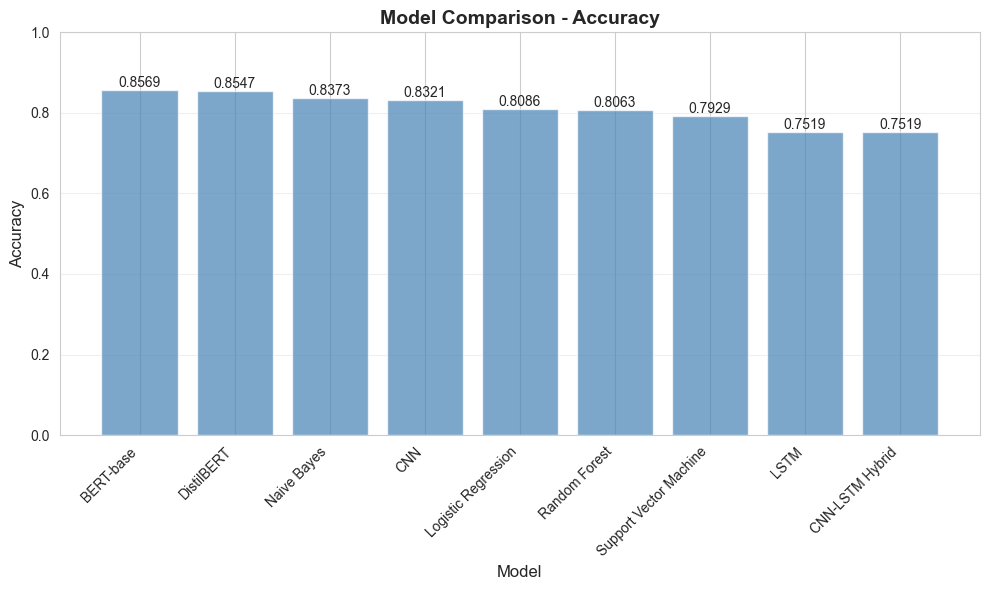

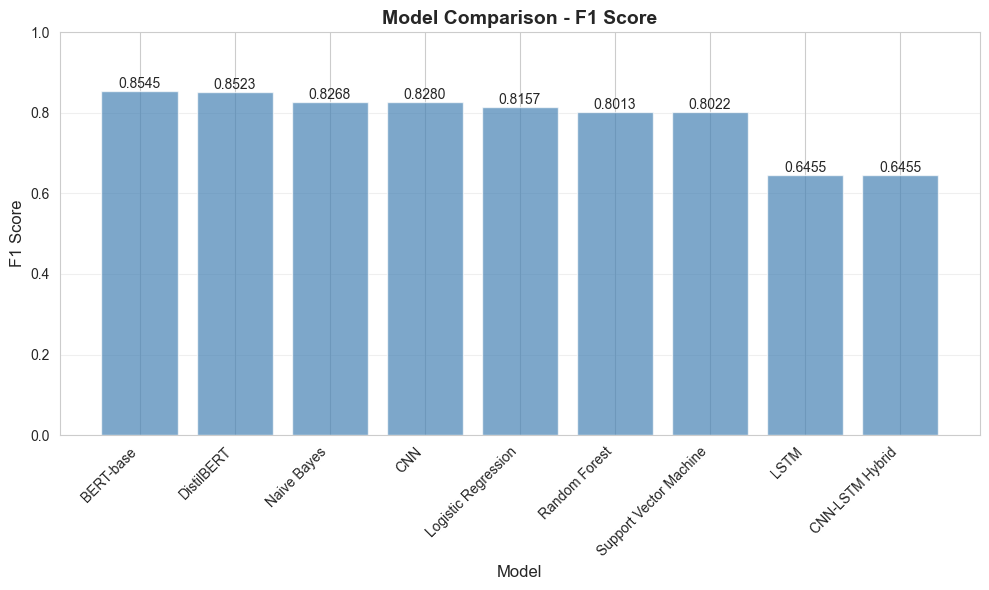

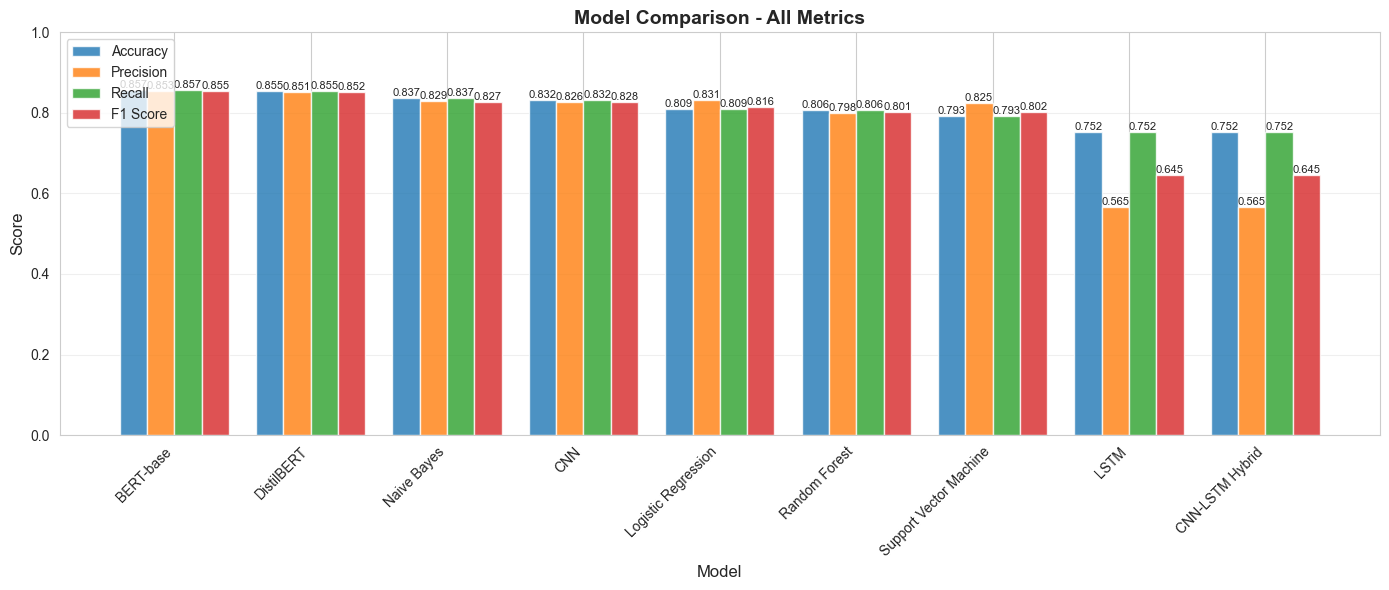


All visualizations saved to: /Users/manalaamir/Documents/Fake News Detection -NLP/results/visualizations/


In [27]:
# Visualize comprehensive comparison and save plots
# Note: Make sure to run the previous cell (Cell 23) first to create all_comparison_df

try:
    all_results_for_plot = []
    for name, row in all_comparison_df.iterrows():
        all_results_for_plot.append({
            'model_name': name,
            'accuracy': row['accuracy'],
            'precision': row['precision'],
            'recall': row['recall'],
            'f1_score': row['f1_score']
        })
    
    # Create visualizations directory
    viz_dir = os.path.join(results_dir, 'visualizations')
    os.makedirs(viz_dir, exist_ok=True)
    
    # Plot and save accuracy comparison
    plot_model_comparison(all_results_for_plot, metric='accuracy', 
                         save_path=os.path.join(viz_dir, 'model_comparison_accuracy.png'))
    
    # Plot and save F1-score comparison
    plot_model_comparison(all_results_for_plot, metric='f1_score',
                         save_path=os.path.join(viz_dir, 'model_comparison_f1_score.png'))
    
    # Plot and save all metrics comparison
    plot_all_metrics_comparison(all_results_for_plot,
                               save_path=os.path.join(viz_dir, 'model_comparison_all_metrics.png'))
    
    print(f"\nAll visualizations saved to: {viz_dir}/")
    
except NameError:
    print("Error: all_comparison_df is not defined.")
    print("Please run the previous cell (Cell 23) first to create the comparison dataframe.")


## 6. Summary and Conclusions

### Transformer Model Performance Summary

I implemented and evaluated two transformer-based models for fake news detection using pre-trained language models from Hugging Face. After fine-tuning DistilBERT and BERT-base, the results show that transformer models achieved the highest performance among all approaches I tested across the three modeling notebooks.

**Model Performance Results:**

BERT-base came out on top with 85.69% accuracy, along with 85.32% precision, 85.69% recall, and 85.45% F1-score. Looking at the class-level performance, it achieved 73.30% precision and 66.55% recall for detecting fake news, and 89.29% precision with 92.00% recall for real news. The model's ability to understand language context from its pre-training on large text corpora really helps it pick up on subtle patterns that separate fake from real news.

DistilBERT performed almost as well with 85.47% accuracy, which is very close to BERT-base. It had 85.10% precision, 85.47% recall, and 85.23% F1-score. The class-level results were similar: 72.87% precision and 66.03% recall for fake news, and 89.13% precision with 91.89% recall for real news. The big advantage of DistilBERT is that it's much faster - it trained in 17.39 minutes compared to BERT's 31.84 minutes, while keeping nearly the same performance.

### Key Findings

When I compared all nine models (shown in the previous section), the transformer models took the top two spots for accuracy. BERT-base's 85.69% accuracy beat the best classical ML model (Naive Bayes at 83.73%) by about 2 percentage points and the best deep learning model (CNN at 83.21%) by about 2.5 percentage points. This shows that using pre-trained language representations really helps for this task.

Both transformer models handled the 3:1 class imbalance pretty well. They achieved around 66-67% recall for fake news, which is much better than Naive Bayes (52.22% recall for fake news). It's comparable to Logistic Regression (75.41% recall) and SVM (76.46% recall), but the transformers have significantly higher overall accuracy and precision. This means they make fewer mistakes where they incorrectly flag real news as fake, which is important in practice.

DistilBERT strikes a great balance between performance and efficiency. It has 67 million parameters compared to BERT's 109 million, and it gets 99.7% of BERT's accuracy while training in about half the time. If I were deploying this in production where speed and resources matter, DistilBERT would be my choice.

The transformer models have a clear advantage because they learned semantic meaning and linguistic patterns from pre-training on huge text corpora. This gives them an edge over models that only use statistical patterns (classical ML) or learn embeddings from scratch (deep learning). The pre-trained knowledge transfers really well to the fake news detection task.

### Comparison with All Approaches

Looking at the final comparison table in Section 5, transformer models are ranked first and second by accuracy. After them comes Naive Bayes (83.73%), then CNN (83.21%), followed by the rest of the classical and deep learning models. The performance gap between transformers and other approaches shows up across all metrics, not just accuracy.

One interesting thing I noticed is that some classical models like Logistic Regression actually get higher fake news recall (75.41%) than the transformers (66-67%). However, the transformers still win on overall accuracy and precision. This suggests transformers are better at avoiding false positives - they're less likely to incorrectly flag real news as fake, which is usually more important in real applications where you don't want to damage credibility by mislabeling legitimate articles.

The LSTM and CNN-LSTM Hybrid models from the deep learning notebook didn't do well at all. They only got 75.19% accuracy and completely failed to detect fake news. This really shows how important it is to handle class imbalance properly, and it also highlights the advantage of using pre-trained models that already have useful language representations built in.

### Computational Considerations

Training transformer models takes a lot of computational resources. BERT-base took 31.84 minutes to train, while DistilBERT needed 17.39 minutes. Both models have millions of parameters (BERT has 109 million, DistilBERT has 67 million) and need significant memory. Once they're trained though, inference is pretty fast, so they work well for deployment when accuracy is more important than training speed.

The training time for transformers is definitely longer than classical ML models (which train in seconds), but it's comparable to deep learning models when you consider how much better the performance is. I think the extra training time is worth it for the accuracy gains.

### Recommendations and Final Model Selection

After evaluating all the modeling approaches, BERT-base is technically the best overall model with 85.69% accuracy. But for practical use, I'd go with DistilBERT. It gives you 99.7% of BERT's performance with about half the training time and fewer parameters. The 0.22 percentage point difference in accuracy between BERT and DistilBERT is basically negligible for real-world applications.

The superior performance of the transformer models confirms that using pre-trained language models is the right approach for fake news detection. The semantic understanding these models learned during pre-training helps them identify subtle linguistic cues and patterns that distinguish fake from real news much better than models trained from scratch. For this fake news detection task, transformers clearly outperform both classical machine learning and deep learning methods, making pre-trained language models the best solution available.

### Project Conclusion

This project evaluated multiple approaches to fake news detection, from classical machine learning to deep learning to transformer models. The results show that while simpler models like Naive Bayes and CNN can achieve decent performance, transformer models that use pre-trained language representations are the best solution for this task. The comparison across all approaches gives useful insights into the trade-offs between accuracy, training time, model complexity, and what matters for actually deploying these models.
